In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle

# Simulation 

In [5]:
def random():
    A = np.random.random()
    B = np.random.random()
    if B>=.5:
        C = 1
    else:
        C = -1
    return A*C    

def Noise(I): #original noise function
    N = []
    for i in range(0,len(I)):
        N.append(I[i]+(I[i]/10)*random())
    return N

def NoiseG(I):  #noise with gaussian distribution
    N = []
    for i in range(0,len(I)):
        N.append(I[i] + (I[i]/10)*np.random.normal(0,1,1)[0])
    return N

def NoiseR(I): # noise with rician distribution
    N = []
    for i in range(0,len(I)):
        g1 = np.random.normal(0,.5,1)
        g2 = np.random.normal(0,.5,1)
        R = np.sqrt(g1**2 + g2**2)[0]
        N.append(I[i] +(I[i]/10)*R)
    return N

def func(b,f,Ds,D):
    Sig = f*np.exp(-Ds*b)+(1-f)*np.exp(-D*b) #IVIM model signal
    return Sig

def func1(b,f,D):
    return (1-f)*np.exp(-D*b)

def func2(b,f,Ds):
    return f*np.exp(-Ds*b)

def percentdiff(A,B):
    pd = 200*np.abs(A-B)/(A+B)
    return pd

def percenterr(T,M):
    return 100*(T-M)/T

def ivim(Bvals,f,Ds,D):
    S = []
    for i in range(len(Bvals)):
        S.append(f*np.exp(-Ds*Bvals[i])+(1-f)*np.exp(-D*Bvals[i]))
    return S

def percenterr(T,M):
    return 100*(T-M)/T
B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
def diffivim(Bvals,f,D): #high b values
    S = []
    for i in range(len(Bvals)):
        S.append(func1(Bvals[i],f,D))
    return S

def plotfunc2(Bvals,f,Ds):
    S = []
    for i in range(len(Bvals)):
        S.append(func2(Bvals[i],f,Ds))
    return S
# now comparing different fits (just to get pretty plot)
B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
def twostepfit(IVIM,Bvals,B_500): #for Fine B vals
    p01 = [0.05,.0009] #f,D best
    p02 = [0.05,.009] #f,Ds best
    popt,pcov = op.curve_fit(func1,Bvals[B_500:],IVIM[B_500:], p01,bounds = (0,[1,1]))
    fF = popt[0]
    DF = popt[1]
    IVIM2 = np.array(IVIM) - np.array(diffivim(Bvals,fF,DF))
    popt,pcov = op.curve_fit(func2,Bvals[:B_500-1],IVIM2[:B_500-1], p02,bounds = (0,[1,1]))
    fF2 = popt[0]
    DsF = popt[1]
    return [fF2,DsF,DF]

def splitfit(IVIM,Bvals,B_500): #B_500 is the index of the b value that is >=500 (13)
    #p01 = [.02,.0058] #f,D
    p01 = [.05,.0009]
    popt,pcov = op.curve_fit(func1,Bvals[B_500:],IVIM[B_500:], p01,bounds = (0,[.1,1]),maxfev = 10000)
    f1 = popt[0]
    D_fit = popt[1]
    p02 = [.05,.009,D_fit] #f,Ds,D
    popt,pcov = op.curve_fit(func,Bvals,IVIM, p02,bounds = ([0,0,D_fit],[1,1,D_fit+.001]),maxfev = 10000)
    fF = popt[0]
    DsF = popt[1]
    DF = popt[2]
    return [fF,DsF,DF]
def simplefit(IVIM,Bvals):
    p0 = [.05,.009,.0009] #f, Ds,D best
    popt,pcov = op.curve_fit(func,Bvals,IVIM, p0,bounds = (0,[1,1,1]),maxfev = 10000)
    fF = popt[0]
    DsF = popt[1]
    DF = popt[2]
    return [fF,DsF,DF]
def twosteprun(f,Ds,D,S,B_500):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = twostepfit(S,B,B_500)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]
def splitrun(f,Ds,D,S,B_500):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = splitfit(S,B,B_500)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]
def simplerun(f,Ds,D,S):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = simplefit(S,B)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]

def twosteprunBs(f,Ds,D,S,B_500,B):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = twostepfit(S,B,B_500)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]

def simplerunBs(f,Ds,D,S,B):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = simplefit(S,B)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]

def splitrunBs(f,Ds,D,S,B_500,B):
    #SigN = ivim(B,f,Ds,D)
    [fF,DsF,DF] = splitfit(S,B,B_500)
    return [fF,DsF,DF],[percenterr(f,fF),percenterr(Ds,DsF),percenterr(D,DF)]


def NoiseRice(I,sigma): # noise with rician distribution
    N = [] 
    #v = .79 # calculated from images on 6/11/19
    #sigma = .013 #(std of noise!)
    #v = 0.00434 #scaled = .79/182
    v = .005816 #scaled 6/27/19
    b = v/sigma
    r = rice.rvs(b, scale = sigma, size=len(I))
    for i in range(0,len(I)):
        N.append(I[i] +r[i]) #SNR = 1,10,22,100,150,inf
    return N


# THRESHOLD B VALUE

In [10]:
# comparing b values for 2step run
#B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
TSR5 = [] #2step run 500
TSR2 = [] #2step run 200
TSR3 = [] #2step run 300
for i in range(10000):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()
    SigN = ivim(B,f,Ds,D)
    S = NoiseRice(SigN,.01) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S,5)
    TSR5.append(ferr),TSR5.append(Dserr),TSR5.append(Derr)
    [fB,DsB,DB],[ferr3,Dserr3,Derr3] = twosteprun(f,Ds,D,S,3)
    TSR3.append(ferr3),TSR3.append(Dserr3),TSR3.append(Derr3)
    [fB,DsB,DB],[ferr2,Dserr2,Derr2] = twosteprun(f,Ds,D,S,2)
    TSR2.append(ferr2),TSR2.append(Dserr2),TSR2.append(Derr2)


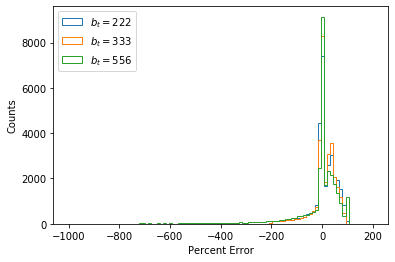

average error:  8.68941299420006
average error:  7.298946490760436
average error:  -48.76040739985646
absolute error:  33.408401038401635
absolute error:  31.267971510381912
absolute error:  86.19447218264696


In [11]:
# just making plots for draft of paper, compare B_500 = 2, vs 5 (for example)
# with GAUSSIAN noise
#pl.title('Percent Error Distribution Rician Noise')
pl.hist(TSR2,bins = 100,range =(-1000,200),histtype = 'step',label = '$b_t = 222$')
pl.hist(TSR3,bins = 100,range=(-1000,200),histtype = 'step',label = '$b_t = 333$')
pl.hist(TSR5,bins = 100,range=(-1000,200),histtype = 'step',label = '$b_t = 556$')


pl.legend(loc=2)
#pl.text(-990,3000,'10000 runs\n222 MPE = -27.1%\n333 MPE = -123.6%\n556 MPE = -93.9%')
#pl.text(-990,1000,'222 MAPD = 45.7%\n333 MAPD = 157.7%\n556 MAPD = 128.1%')
pl.ylabel('Counts')
pl.xlabel('Percent Error')
#pl.savefig('/Users/neuroimaging/Desktop/btdistribution.tif',dpi=1000)
pl.show()

print('average error: ',np.mean(TSR2))
print('average error: ',np.mean(TSR3))
print('average error: ',np.mean(TSR5))
print('absolute error: ', np.sum([abs(i) for i in TSR2])/len(TSR2))
print('absolute error: ', np.sum([abs(i) for i in TSR3])/len(TSR3))
print('absolute error: ', np.sum([abs(i) for i in TSR5])/len(TSR5))

In [4]:
# Comparing b values for split fit
TSR5 = [] #2step run 500
TSR2 = [] #2step run 200
TSR3 = [] #2step run 300
for i in range(10000):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()
    SigN = ivim(B,f,Ds,D)
    S = NoiseRice(SigN,.01) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = splitrun(f,Ds,D,S,5)
    TSR5.append(ferr),TSR5.append(Dserr),TSR5.append(Derr)
    [fB,DsB,DB],[ferr3,Dserr3,Derr3] = splitrun(f,Ds,D,S,3)
    TSR3.append(ferr3),TSR3.append(Dserr3),TSR3.append(Derr3)
    [fB,DsB,DB],[ferr2,Dserr2,Derr2] = splitrun(f,Ds,D,S,2)
    TSR2.append(ferr2),TSR2.append(Dserr2),TSR2.append(Derr2)


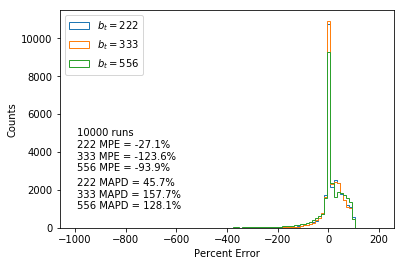

average error:  -126.91548925481962
average error:  -109.78147615755041
average error:  -139.9316214348476
absolute error:  168.25317644307896
absolute error:  150.24248274080165
absolute error:  182.91273206858213


In [5]:
# just making plots for draft of paper, compare B_500 = 2, vs 5 (for example)
# with GAUSSIAN noise
#pl.title('Percent Error Distribution Rician Noise')
pl.hist(TSR2,bins = 100,range =(-1000,200),histtype = 'step',label = '$b_t = 222$')
pl.hist(TSR3,bins = 100,range=(-1000,200),histtype = 'step',label = '$b_t = 333$')
pl.hist(TSR5,bins = 100,range=(-1000,200),histtype = 'step',label = '$b_t = 556$')


pl.legend(loc=2)
pl.text(-990,3000,'10000 runs\n222 MPE = -27.1%\n333 MPE = -123.6%\n556 MPE = -93.9%')
pl.text(-990,1000,'222 MAPD = 45.7%\n333 MAPD = 157.7%\n556 MAPD = 128.1%')
pl.ylabel('Counts')
pl.xlabel('Percent Error')
#pl.savefig('/Users/neuroimaging/Desktop/btdistribution.tif',dpi=1000)
pl.show()

print('average error: ',np.mean(TSR2))
print('average error: ',np.mean(TSR3))
print('average error: ',np.mean(TSR5))
print('absolute error: ', np.sum([abs(i) for i in TSR2])/len(TSR2))
print('absolute error: ', np.sum([abs(i) for i in TSR3])/len(TSR3))
print('absolute error: ', np.sum([abs(i) for i in TSR5])/len(TSR5))

# Fit Algorithms

In [12]:
# comparing all fits on same initial values for consistency
#B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
TSR2step = [] #2step run b = 200
TSRsplit = [] #split run b = 200
TSRsimple = [] # no threshold b
for i in range(10000):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()
    SigN = ivim(B,f,Ds,D)
    S = NoiseRice(SigN,.01) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S,2)
    TSR2step.append(ferr),TSR2step.append(Dserr),TSR2step.append(Derr)
    [fB,DsB,DB],[ferr3,Dserr3,Derr3] = splitrun(f,Ds,D,S,2)
    TSRsplit.append(ferr3),TSRsplit.append(Dserr3),TSRsplit.append(Derr3)
    [fB,DsB,DB],[ferr2,Dserr2,Derr2] = simplerun(f,Ds,D,S)
    TSRsimple.append(ferr2),TSRsimple.append(Dserr2),TSRsimple.append(Derr2)


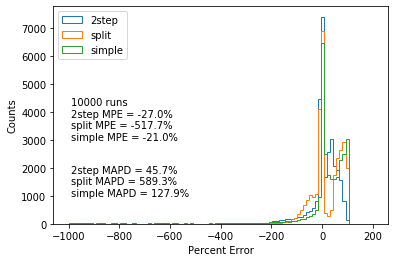

average error:  8.68941299420006
average error:  16.440434875463072
average error:  -158.98887151192724
absolute error:  33.408401038401635
absolute error:  44.10832459946061
absolute error:  227.2201708095411


In [13]:
# just making plots for draft of paper, compare B_500 = 2, vs 5 (for example)
# with RICIAN noise
#pl.title('Percent Error Distribution Rician Noise')
pl.hist(TSR2,bins = 100,range =(-1000,200),histtype = 'step',label = '2step')
pl.hist(TSRsplit,bins = 100,range=(-1000,200),histtype = 'step',label = 'split')
pl.hist(TSRsimple,bins = 100,range=(-1000,200),histtype = 'step',label = 'simple')


pl.legend(loc=2)
pl.text(-990,3000,'10000 runs\n2step MPE = -27.0%\nsplit MPE = -517.7%\nsimple MPE = -21.0%')
pl.text(-990,1000,'2step MAPD = 45.7%\nsplit MAPD = 589.3%\nsimple MAPD = 127.9%')
pl.xlabel('Percent Error')
pl.ylabel('Counts')
pl.savefig('/Users/neuroimaging/Desktop/fitalgdistribution.tif',dpi=1000)
pl.show()

print('average error: ',np.mean(TSR2))
print('average error: ',np.mean(TSRsplit))
print('average error: ',np.mean(TSRsimple))
print('absolute error: ', np.sum([abs(i) for i in TSR2])/len(TSR2))
print('absolute error: ', np.sum([abs(i) for i in TSRsplit])/len(TSRsplit))
print('absolute error: ', np.sum([abs(i) for i in TSRsimple])/len(TSRsimple))


# Number of b values
## edit: now comparing to previous literature b values, with 2step run. See IVIM_PatientbValues_Sim.ipynb

# comparing NUMBER OF b values for 2step run
B5 = [0,111,222,556,778,1000]
B10 = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
B19 = [0, 22, 44, 67, 89, 111, 133, 156, 178, 200, 222, 333, 444, 556, 667, 778, 889, 1000]
TSR10 = [] #2step run 10 B values
TSR19 = [] #2step run 19 B values
TSR5 = [] #2step run 5 B values
for i in range(10000):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()
    #5 b values
    Sig5 = ivim(B5,f,Ds,D)
    S5 = NoiseRice(Sig5,.0135) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprunBs(f,Ds,D,S5,2,B5)
    TSR5.append(ferr),TSR5.append(Dserr),TSR5.append(Derr)
    #10 b values
    Sig10 = ivim(B10,f,Ds,D)
    S10 = NoiseR(Sig10) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprunBs(f,Ds,D,S10,2,B10)
    TSR10.append(ferr),TSR10.append(Dserr),TSR10.append(Derr)
    #19 b values
    Sig19 = ivim(B19,f,Ds,D)
    S19 = NoiseR(Sig19) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprunBs(f,Ds,D,S19,11,B19)
    TSR19.append(ferr),TSR19.append(Dserr),TSR19.append(Derr)
    

#pl.title('Percent Error Distribution Rician Noise')
pl.hist(TSR5,bins = 100,range=(-1000,200),histtype = 'step',label = '5 B vals')

pl.hist(TSR10,bins = 100,range =(-1000,200),histtype = 'step',label = '10 B vals')
pl.hist(TSR19,bins = 100,range=(-1000,200),histtype = 'step',label = '19 B vals')

pl.legend(loc=2)
pl.text(-990,3000,'10000 runs\n5 MPE = -34.5%\n10 MPE = -27.2%\n19 MPE = -26.6%')
pl.text(-990,1000,'5 MAPD = 52.6%\n10 MAPD = 46.1%\n19 MAPD = 54.4%')
#pl.savefig('/Users/neuroimaging/Desktop/PercentErrorB_500Rician.tif',dpi=180)
pl.show()

print('average error: ',np.mean(TSR5))
print('average error: ',np.mean(TSR10))
print('average error: ',np.mean(TSR19))
print('absolute error: ', np.sum([abs(i) for i in TSR5])/len(TSR5))
print('absolute error: ', np.sum([abs(i) for i in TSR10])/len(TSR10))
print('absolute error: ', np.sum([abs(i) for i in TSR19])/len(TSR19))

# comparing NUMBER OF b values for simple run
B5 = [0,111,222,444,667,888,1000]
B10 = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
B19 = [0,0, 22, 44, 67, 89, 111, 133, 156, 178, 200, 222, 333, 444, 556, 667, 778, 889, 1000]
TSR10 = [] #2step run 10 B values
TSR19 = [] #2step run 19 B values
TSR5 = [] #2step run 5 B values
for i in range(100):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()
    #5 b values
    Sig5 = ivim(B5,f,Ds,D)
    S5 = NoiseR(Sig5) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = simplerunBs(f,Ds,D,S5,B5)
    TSR5.append(ferr),TSR5.append(Dserr),TSR5.append(Derr)
    #10 b values
    Sig10 = ivim(B10,f,Ds,D)
    S10 = NoiseR(Sig10) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = simplerunBs(f,Ds,D,S10,B10)
    TSR10.append(ferr),TSR10.append(Dserr),TSR10.append(Derr)
    #19 b values
    Sig19 = ivim(B19,f,Ds,D)
    S19 = NoiseR(Sig19) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = simplerunBs(f,Ds,D,S19,B19)
    TSR19.append(ferr),TSR19.append(Dserr),TSR19.append(Derr)
    

In [12]:
#pl.title('Percent Error Distribution Rician Noise')
#pl.hist(TSR5,bins = 100,range=(-1000,200),histtype = 'step',label = '5 B vals')

#pl.hist(TSR10,bins = 100,range =(-1000,200),histtype = 'step',label = '10 B vals')
#pl.hist(TSR19,bins = 100,range=(-1000,200),histtype = 'step',label = '19 B vals')

#pl.legend(loc=2)
#pl.text(-990,3000,'10000 runs\n5 MPE = -34.5%\n10 MPE = -27.2%\n19 MPE = -26.6%')
#pl.text(-990,1000,'5 MAPD = 52.6%\n10 MAPD = 46.1%\n19 MAPD = 54.4%')
#pl.savefig('/Users/neuroimaging/Desktop/PercentErrorB_500Rician.tif',dpi=180)
#pl.show()

print('average error: ',np.mean(TSR5))
print('average error: ',np.mean(TSR10))
print('average error: ',np.mean(TSR19))
print('absolute error: ', np.sum([abs(i) for i in TSR5])/len(TSR5))
print('absolute error: ', np.sum([abs(i) for i in TSR10])/len(TSR10))
print('absolute error: ', np.sum([abs(i) for i in TSR19])/len(TSR19))

average error:  -35.165492206
average error:  -19.9260557325
average error:  42.509813818
absolute error:  144.397282455
absolute error:  128.653896983
absolute error:  74.3102620166


In [37]:
# comparing NUMBER OF b values for 2step run
B5 = [0,111,222,444,667,888,1000]
B10 = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
B19 = [0,0, 22, 44, 67, 89, 111, 133, 156, 178, 200, 222, 333, 444, 556, 667, 778, 889, 1000]
TSR10 = [] #2step run 10 B values
TSR19 = [] #2step run 19 B values
TSR5 = [] #2step run 5 B values
for i in range(10000):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()
    #5 b values
    Sig5 = ivim(B5,f,Ds,D)
    S5 = NoiseR(Sig5) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprunBs(f,Ds,D,S5,2,B5)
    TSR5.append(ferr),TSR5.append(Dserr),TSR5.append(Derr)
    #10 b values
    Sig10 = ivim(B10,f,Ds,D)
    S10 = NoiseR(Sig10) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprunBs(f,Ds,D,S10,2,B10)
    TSR10.append(ferr),TSR10.append(Dserr),TSR10.append(Derr)
    #19 b values
    Sig19 = ivim(B19,f,Ds,D)
    S19 = NoiseR(Sig19) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprunBs(f,Ds,D,S19,11,B19)
    TSR19.append(ferr),TSR19.append(Dserr),TSR19.append(Derr)
    

/Users/Mira/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


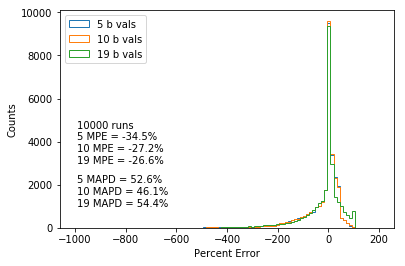

average error:  -27.8027121384
average error:  -26.3966186892
average error:  -27.02080042
absolute error:  46.211559785
absolute error:  44.9526245473
absolute error:  53.8352200934


In [40]:
#pl.title('Percent Error Distribution Rician Noise')
pl.hist(TSR5,bins = 100,range=(-1000,200),histtype = 'step',label = '5 b vals')

pl.hist(TSR10,bins = 100,range =(-1000,200),histtype = 'step',label = '10 b vals')
pl.hist(TSR19,bins = 100,range=(-1000,200),histtype = 'step',label = '19 b vals')

pl.legend(loc=2)
pl.text(-990,3000,'10000 runs\n5 MPE = -34.5%\n10 MPE = -27.2%\n19 MPE = -26.6%')
pl.text(-990,1000,'5 MAPD = 52.6%\n10 MAPD = 46.1%\n19 MAPD = 54.4%')
pl.xlabel('Percent Error')
pl.ylabel('Counts')
pl.savefig('/Users/neuroimaging/Desktop/bvalnum.tif',dpi=1000)
pl.show()

print('average error: ',np.mean(TSR5))
print('average error: ',np.mean(TSR10))
print('average error: ',np.mean(TSR19))
print('absolute error: ', np.sum([abs(i) for i in TSR5])/len(TSR5))
print('absolute error: ', np.sum([abs(i) for i in TSR10])/len(TSR10))
print('absolute error: ', np.sum([abs(i) for i in TSR19])/len(TSR19))

# SNR 

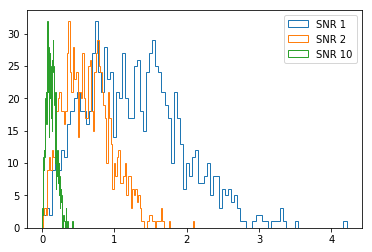

In [72]:
def NoiseR(I): # noise with rician distribution
    N = []
    N2 = []
    N10 = []
    G = []
    for i in range(0,len(I)):
        g1 = np.random.normal(0,.5,1) #mean, std, #of values
        g2 = np.random.normal(0,.5,1)
        R = np.sqrt(g1**2 + g2**2)[0]
        N.append(R)
        N2.append(R/2)
        N10.append(R/10)
        G.append(g1[0])
        #N.append(I[i] +(I[i]/10)*R)
    return N,N2,N10,G

I = np.linspace(0,10,1000)
N,N2,N10,G =NoiseR(I)
pl.hist(N,bins = 100,histtype = 'step',label = 'SNR 1')
pl.hist(N2,bins = 100,histtype = 'step',label = 'SNR 2')
pl.hist(N10,bins = 100,histtype = 'step',label = 'SNR 10')

pl.legend()
pl.show()
#N


# validation that multiplying gaussian relatively similar to 
# changing STD. 
G1 = []
G2 = []
for i in range(0,1000):
    g = np.random.normal(0,1,1) #mean, std, #of values
    G1.append(10*g[0])
    g2 = np.random.normal(0,10,1)
    G2.append(g2[0])
pl.hist(G1,bins = 100,histtype = 'step',label = 'sig 10')
pl.hist(G2,bins = 100,histtype = 'step',label = 'times 10')
pl.legend()
pl.show()

#YAY OK BASICALLY THE SAME phew. 


In [65]:
def NoiseRSNR(I,SNR): # noise with rician distribution
    N = [] 
    for i in range(0,len(I)):
        g1 = np.random.normal(0,1,1) #mean, std, #of values
        g2 = np.random.normal(0,1,1) #std has been .5... I LIED ABOUT SNR oh no
        R = np.sqrt(g1**2 + g2**2)[0]
        #N.append(R)
        #N2.append(R/2)
        #N10.append(R/10)
        #G.append(g1[0])
        N.append(I[i] +(I[i]/SNR)*R) #SNR = 1,10,22,100,150,inf
    return N

In [66]:
# comparing SNR for 2step, 222, 10 bvals
B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
TSR = [] #SNR1
TSR10 = [] #SNR10
TSR22 = [] #SNR22
TSR100 = [] #SNR100
TSRinf = [] #no noise
for i in range(10000):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()
    #SNR1
    Sig = ivim(B,f,Ds,D)
    S1 = NoiseRSNR(Sig,1) #SNR1
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S1,2)
    TSR.append(ferr),TSR.append(Dserr),TSR.append(Derr)
    #SNR10
    Sig10 = ivim(B,f,Ds,D)
    S10 = NoiseRSNR(Sig10,10) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S10,2)
    TSR10.append(ferr),TSR10.append(Dserr),TSR10.append(Derr)
    #SNR22
    Sig22 = ivim(B,f,Ds,D)
    S22 = NoiseRSNR(Sig22,22) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S22,2)
    TSR22.append(ferr),TSR22.append(Dserr),TSR22.append(Derr)
    #SNR100
    Sig100 = ivim(B,f,Ds,D)
    S100 = NoiseRSNR(Sig100,100) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S100,2)
    TSR100.append(ferr),TSR100.append(Dserr),TSR100.append(Derr)
    #SNRinf
    Sig = ivim(B,f,Ds,D)
    #S22 = NoiseRSNR(Sig22,22) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,Sig,2)
    TSRinf.append(ferr),TSRinf.append(Dserr),TSRinf.append(Derr)

/Users/Mira/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


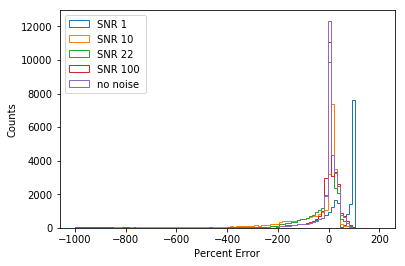

should get worse to better
average error 1:  -649.659849034
average error 10:  -73.8880495327
average error 22:  -23.1686966704
average error 100:  -0.399868147322
average error inf:  0.5191545162
absolute error 1:  720.884185915
absolute error 10:  94.2975877841
absolute error 22:  42.1298842385
absolute error 100:  24.8550946913
absolute error: inf 23.1498563018


In [67]:
#pl.title('Percent Error Distribution Rician Noise')
pl.hist(TSR,bins = 100,range=(-1000,200),histtype = 'step',label = 'SNR 1')
pl.hist(TSR10,bins = 100,range=(-1000,200),histtype = 'step',label = 'SNR 10')
pl.hist(TSR22,bins = 100,range=(-1000,200),histtype = 'step',label = 'SNR 22')
pl.hist(TSR100,bins = 100,range =(-1000,200),histtype = 'step',label = 'SNR 100')
pl.hist(TSRinf,bins = 100,range=(-1000,200),histtype = 'step',label = 'no noise ')

pl.legend(loc=2)
#pl.text(-990,3000,'10000 runs\n5 MPE = -34.5%\n10 MPE = -27.2%\n19 MPE = -26.6%')
#pl.text(-990,1000,'5 MAPD = 52.6%\n10 MAPD = 46.1%\n19 MAPD = 54.4%')
pl.xlabel('Percent Error')
pl.ylabel('Counts')
#pl.savefig('/Users/neuroimaging/Desktop/bvalnum.tif',dpi=1000)
pl.show()

print('should get worse to better')
print('average error 1: ',np.mean(TSR))
print('average error 10: ',np.mean(TSR10))
print('average error 22: ',np.mean(TSR22))
print('average error 100: ',np.mean(TSR100))
print('average error inf: ',np.mean(TSRinf))
print('absolute error 1: ', np.sum([abs(i) for i in TSR])/len(TSR))
print('absolute error 10: ', np.sum([abs(i) for i in TSR10])/len(TSR10))
print('absolute error 22: ', np.sum([abs(i) for i in TSR22])/len(TSR22))
print('absolute error 100: ', np.sum([abs(i) for i in TSR100])/len(TSR100))
print('absolute error: inf', np.sum([abs(i) for i in TSRinf])/len(TSRinf))

# checking SNR, STD, 
def NoiseR(I,std): # noise with rician distribution
    N = []
    N2 = []
    N10 = []
    G = []
    for i in range(0,len(I)):
        g1 = np.random.normal(0,std,1) #mean, std, #of values
        g2 = np.random.normal(0,std,1)
        R = np.sqrt(g1**2 + g2**2)[0]
        N.append(R)
        N2.append(R/2)
        N10.append(R/10)
        G.append(g1[0])
        #N.append(I[i] +(I[i]/10)*R)
    return N,N2,N10,G

I = np.linspace(0,10,1000)
N,N2,N10,G =NoiseR(I,1)
pl.hist(N,bins = 100,histtype = 'step',label = 'SNR 1')
pl.hist(N2,bins = 100,histtype = 'step',label = 'SNR 2')
pl.hist(N10,bins = 100,histtype = 'step',label = 'SNR 10')
pl.title('STD = 1')
pl.xlim(0,5)
pl.legend()
pl.show()
#N

N,N2,N10,G =NoiseR(I,.5)
pl.hist(N,bins = 100,histtype = 'step',label = 'SNR 1')
pl.hist(N2,bins = 100,histtype = 'step',label = 'SNR 2')
pl.hist(N10,bins = 100,histtype = 'step',label = 'SNR 10')
pl.title('STD = .5')
pl.legend()
pl.xlim(0,5)
pl.show()

#So SNR = Signal/STD.
#small STD = large SNR = smaller distribution = green = good

# testing different applications of Rician Noise
def NoiseR1(I,SNR): # noise with rician distribution mira's
    N = []
    for i in range(0,len(I)):
        sigma = I[i]/SNR
        g1 = np.random.normal(0,.5,1) #mean, std, #of values
        g2 = np.random.normal(0,.5,1)
        R = np.sqrt(g1**2 + g2**2)[0]
        N.append(I[i] + sigma*R)
    return N

def NoiseR2(I,SNR): # noise with rician distribution aja-fernandez's
    N = []
    for i in range(0,len(I)):
        sigma = I[i]/SNR
        g1 = np.random.normal(0,sigma,1) #mean, std, #of values
        g2 = np.random.normal(0,sigma,1)
        N.append(np.sqrt((I[i] + g1[0])**2 + g2[0]**2))
    return N

I = np.linspace(0,10,1000)
N1 =NoiseR1(I,10)
pl.hist(N1,bins = 100,histtype = 'step',label = 'M')
N2 =NoiseR2(I,10)
pl.hist(N2,bins = 100,histtype = 'step',label = 'aja-fernandez')
pl.legend()
pl.show()


# similar distribution @ SNR = 10 

def NoiseRSNR(I,SNR): # noise with rician distribution AJA-FERNANDEZ
    N = [] 
    for i in range(0,len(I)):
        sigma = I[i]/SNR
        g1 = np.random.normal(0,sigma,1) #mean, std, #of values
        g2 = np.random.normal(0,sigma,1)
        N.append(np.sqrt((I[i] + g1[0])**2 + g2[0]**2))
    return N

# comparing SNR for 2step, 222, 10 bvals
B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
TSR = [] #SNR1
TSR5 = [] #SNR5
TSR10 = [] #SNR10
TSR22 = [] #SNR22
TSRinf = [] #no noise
for i in range(10000):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()
    #SNR1
    Sig = ivim(B,f,Ds,D)
    S1 = NoiseRSNR(Sig,1) #SNR1
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S1,2)
    TSR.append(ferr),TSR.append(Dserr),TSR.append(Derr)
    #SNR5
    Sig5 = ivim(B,f,Ds,D)
    S5 = NoiseRSNR(Sig5,5) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S5,2)
    TSR5.append(ferr),TSR5.append(Dserr),TSR5.append(Derr)
    #SNR10
    Sig10 = ivim(B,f,Ds,D)
    S10 = NoiseRSNR(Sig10,10) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S10,2)
    TSR10.append(ferr),TSR10.append(Dserr),TSR10.append(Derr)
    #SNR22
    Sig22 = ivim(B,f,Ds,D)
    S22 = NoiseRSNR(Sig22,22) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S22,2)
    TSR22.append(ferr),TSR22.append(Dserr),TSR22.append(Derr)
    #SNRinf
    Sig = ivim(B,f,Ds,D)
    #S22 = NoiseRSNR(Sig22,22) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,Sig,2)
    TSRinf.append(ferr),TSRinf.append(Dserr),TSRinf.append(Derr)

#pl.title('Percent Error Distribution Rician Noise')
pl.hist(TSR,bins = 100,range=(-1000,200),histtype = 'step',label = 'SNR 1')
pl.hist(TSR5,bins = 100,range =(-1000,200),histtype = 'step',label = 'SNR 5')
pl.hist(TSR10,bins = 100,range=(-1000,200),histtype = 'step',label = 'SNR 10')
pl.hist(TSR22,bins = 100,range=(-1000,200),histtype = 'step',label = 'SNR 22')
pl.hist(TSRinf,bins = 100,range=(-1000,200),histtype = 'step',label = 'no noise ')

pl.legend(loc=2)
#pl.text(-990,3000,'10000 runs\n5 MPE = -34.5%\n10 MPE = -27.2%\n19 MPE = -26.6%')
#pl.text(-990,1000,'5 MAPD = 52.6%\n10 MAPD = 46.1%\n19 MAPD = 54.4%')
pl.xlabel('Percent Error')
pl.ylabel('Counts')
#pl.savefig('/Users/neuroimaging/Desktop/bvalnum.tif',dpi=1000)
pl.show()

print('should get worse to better')
print('average error 1 : ',np.mean(TSR))
print('average error 5 : ',np.mean(TSR5))
print('average error 10 : ',np.mean(TSR10))
print('average error 22 : ',np.mean(TSR22))
print('average error inf: ',np.mean(TSRinf))
print('absolute error 1: ', np.sum([abs(i) for i in TSR])/len(TSR))
print('absolute error 5: ', np.sum([abs(i) for i in TSR5])/len(TSR5))
print('absolute error 10: ', np.sum([abs(i) for i in TSR10])/len(TSR10))
print('absolute error 22: ', np.sum([abs(i) for i in TSR22])/len(TSR22))
print('absolute error inf: ', np.sum([abs(i) for i in TSRinf])/len(TSRinf))

def NoiseRSNR(I,SNR): # noise with ACTUAL-rician distribution MIRA
    N = [] 
    r = rice.rvs(b,scale=1/SNR, size=len(I))
    for i in range(0,len(I)):
        N.append(I[i] + r[i]*I[i])
    return N

# comparing SNR for 2step, 222, 10 bvals
B = [0,111, 222, 333, 444, 556, 667, 778, 889, 1000]
TSR = [] #SNR1
TSR5 = [] #SNR5
TSR10 = [] #SNR10
TSR22 = [] #SNR22
TSRinf = [] #no noise
for i in range(10000):
    f = .05 + .035*random()
    Ds = .009 + .006*random()
    D = .0009 + .0006*random()
    #SNR1
    Sig = ivim(B,f,Ds,D)
    S1 = NoiseRSNR(Sig,1) #SNR1
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S1,2)
    TSR.append(ferr),TSR.append(Dserr),TSR.append(Derr)
    #SNR5
    Sig5 = ivim(B,f,Ds,D)
    S5 = NoiseRSNR(Sig5,5) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S5,2)
    TSR5.append(ferr),TSR5.append(Dserr),TSR5.append(Derr)
    #SNR10
    Sig10 = ivim(B,f,Ds,D)
    S10 = NoiseRSNR(Sig10,10) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S10,2)
    TSR10.append(ferr),TSR10.append(Dserr),TSR10.append(Derr)
    #SNR22
    Sig22 = ivim(B,f,Ds,D)
    S22 = NoiseRSNR(Sig22,22) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,S22,2)
    TSR22.append(ferr),TSR22.append(Dserr),TSR22.append(Derr)
    #SNRinf
    Sig = ivim(B,f,Ds,D)
    #S22 = NoiseRSNR(Sig22,22) #rician noise
    [fB,DsB,DB],[ferr,Dserr,Derr] = twosteprun(f,Ds,D,Sig,2)
    TSRinf.append(ferr),TSRinf.append(Dserr),TSRinf.append(Derr)

# run with 'Actual' Rician noise
#pl.title('Percent Error Distribution Rician Noise')
pl.hist(TSR,bins = 100,range=(-1000,200),histtype = 'step',label = 'SNR 1')
pl.hist(TSR5,bins = 100,range =(-1000,200),histtype = 'step',label = 'SNR 5')
pl.hist(TSR10,bins = 100,range=(-1000,200),histtype = 'step',label = 'SNR 10')
pl.hist(TSR22,bins = 100,range=(-1000,200),histtype = 'step',label = 'SNR 22')
pl.hist(TSRinf,bins = 100,range=(-1000,200),histtype = 'step',label = 'no noise ')

pl.legend(loc=2)
#pl.text(-990,3000,'10000 runs\n5 MPE = -34.5%\n10 MPE = -27.2%\n19 MPE = -26.6%')
#pl.text(-990,1000,'5 MAPD = 52.6%\n10 MAPD = 46.1%\n19 MAPD = 54.4%')
pl.xlabel('Percent Error')
pl.ylabel('Counts')
#pl.savefig('/Users/neuroimaging/Desktop/bvalnum.tif',dpi=1000)
pl.show()

print('should get worse to better')
print('average error 1 : ',np.mean(TSR))
print('average error 5 : ',np.mean(TSR5))
print('average error 10 : ',np.mean(TSR10))
print('average error 22 : ',np.mean(TSR22))
print('average error inf: ',np.mean(TSRinf))
print('absolute error 1: ', np.sum([abs(i) for i in TSR])/len(TSR))
print('absolute error 5: ', np.sum([abs(i) for i in TSR5])/len(TSR5))
print('absolute error 10: ', np.sum([abs(i) for i in TSR10])/len(TSR10))
print('absolute error 22: ', np.sum([abs(i) for i in TSR22])/len(TSR22))
print('absolute error inf: ', np.sum([abs(i) for i in TSRinf])/len(TSRinf))

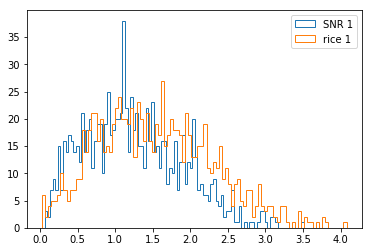

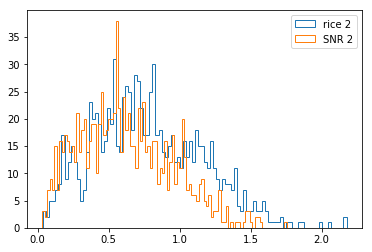

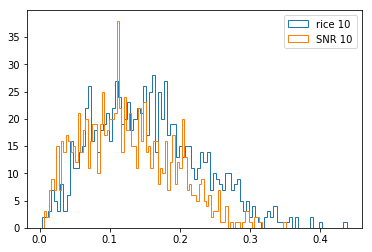

In [84]:
from scipy.stats import rice
b =1
def NoiseR(I): # noise with rician distribution
    N = []
    N2 = []
    N10 = []
    G = []
    for i in range(0,len(I)):
        g1 = np.random.normal(0,1,1) #mean, std, #of values
        g2 = np.random.normal(0,1,1)
        R = np.sqrt(g1**2 + g2**2)[0]
        N.append(R)
        N2.append(R/2)
        N10.append(R/10)
        G.append(g1[0])
        #N.append(I[i] +(I[i]/10)*R)
    return N,N2,N10,G

I = np.linspace(0,10,1000)
N,N2,N10,G =NoiseR(I)
r = rice.rvs(b,scale=1, size=1000) #rician distribution histogram
pl.hist(N,bins = 100,histtype = 'step',label = 'SNR 1')
pl.hist(r,bins=100,histtype='step',label='rice 1')
pl.legend()
pl.show()
r = rice.rvs(b,scale=1/2, size=1000) #rician distribution histogram
pl.hist(r,bins=100,histtype='step',label='rice 2')
pl.hist(N2,bins = 100,histtype = 'step',label = 'SNR 2')
pl.legend()
pl.show()

r = rice.rvs(b,scale=1/10, size=1000) #rician distribution histogram
pl.hist(r,bins=100,histtype='step',label='rice 10')
pl.hist(N10,bins = 100,histtype = 'step',label = 'SNR 10')
pl.legend()
pl.show()

# yay ok it seems to be working, my way of generating noise seems to 
# match Rician noise ish!
# could also just use... Rician noise...

In [85]:
S = rice.std(b, loc=0, scale=1/10)
print(S)
N,N2,N10,G = NoiseR(I)
print(np.std(N10))

0.0775837182934
0.066061820024


In [ ]:
#take b = 0, look at mean signal of dog's brain 
# and divide by std of 'air' (corner of plot)

# ADC: apparent diffusion coefficient, is it D from IVIM?
